In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from config.env_config import Config
from env_nikolai2 import UniswapV3LPGymEnv 

In [2]:
import numpy as np

TICK_MIN = -887_272
TICK_MAX =  887_272

def random_action():

    a0 = np.random.randint(0, 2)                         # 0 or 1
    tick_lower = np.random.randint(TICK_MIN, TICK_MAX)   # inclusive
    tick_upper = np.random.randint(tick_lower + 1, TICK_MAX + 1)
    return np.array([a0, tick_lower, tick_upper], dtype=np.float32)

In [3]:
cfg   = Config()
env   = UniswapV3LPGymEnv(cfg)

state, _ = env.reset()

steps                 = 500
cumulative_pnl_hist   = [env.cumulative_pnl]
time_steps            = [0]

for t in tqdm(range(steps), desc="Simulating"):
    action = random_action()           
    state, reward, done, truncated, info = env.step(action)
    cumulative_pnl_hist.append(env.cumulative_pnl)
    time_steps.append(t + 1)

env.close()

Simulating: 100%|██████████| 500/500 [00:00<00:00, 2363.67it/s]


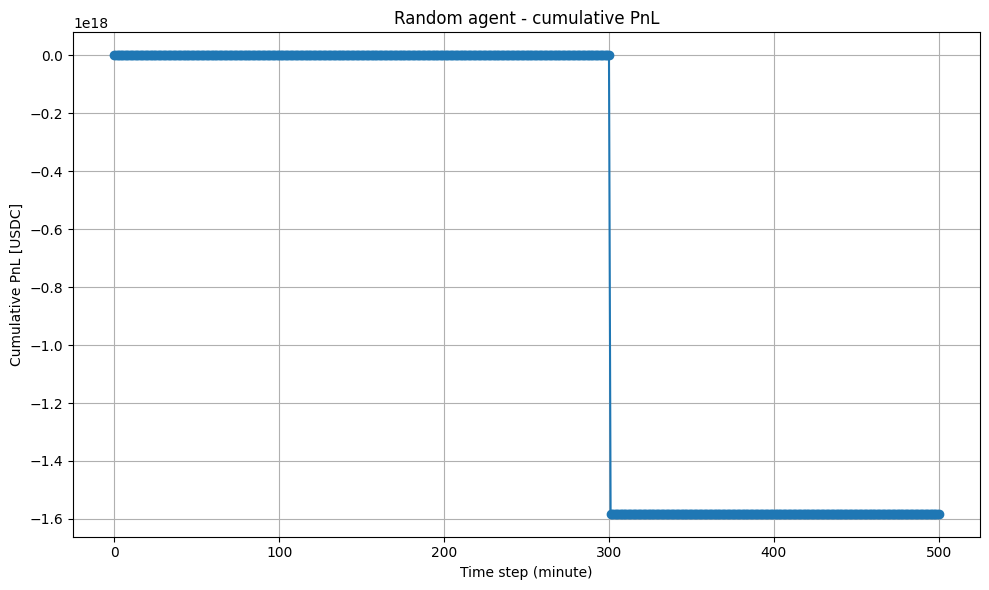

In [4]:
# ──────────────────────────────────────────────────────────────────────────
# 4.  Plot
# ──────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
plt.plot(time_steps, cumulative_pnl_hist, marker="o")
plt.xlabel("Time step (minute)")
plt.ylabel("Cumulative PnL [USDC]")
plt.title("Random agent - cumulative PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

# RL Exper

In [5]:
# !pip install stable-baselines3 --default-timeout=100

In [6]:
# !pip install ipywidgets

In [11]:
# train_uniswap_simple.py
# -----------------------
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ───── your environment ─────
from env_nikolai2 import UniswapV3LPGymEnv
from config.env_config import Config

# ───── RL + utils ─────
import gymnasium as gym
from gymnasium.wrappers import TimeLimit, RecordEpisodeStatistics, FlattenObservation
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

# ───── hyper‑params you might tweak ─────
TOTAL_TIMESTEPS      = 10_000     # training steps
MAX_EPISODE_MINUTES  = 1_000     # one‑day cap

# ╭────────────────────────── helpers ───────────────────────────╮
def make_env():
    cfg = Config()
    env = UniswapV3LPGymEnv(cfg, feat_num=19)

    env = TimeLimit(env, max_episode_steps=MAX_EPISODE_MINUTES)
    env = RecordEpisodeStatistics(env)
    env = FlattenObservation(env)

    logs_dir = Path("logs");  logs_dir.mkdir(exist_ok=True)
    env = Monitor(env, str(logs_dir), allow_early_resets=True)   # ← str() fix
    return env


def plot_learning_curve(monitor_csv: Path, title: str = "Learning curve") -> None:
    df = pd.read_csv(monitor_csv, comment="#")
    df["rolling_return"] = df["r"].rolling(window=20).mean()
    plt.figure(figsize=(8, 4))
    plt.plot(df["l"], df["rolling_return"])
    plt.xlabel("Episode"); plt.ylabel("Reward (20‑ep MA)")
    plt.title(title); plt.grid(True)
    plt.tight_layout(); plt.show()


# ╭────────────────────────── training ──────────────────────────╮
def main():
    # 1⃣  make vectorised env
    env = DummyVecEnv([make_env])

    # 2⃣  define agent
    model = PPO(
        "MlpPolicy",
        env,
        # n_steps       = 2048,
        n_steps       = 1024,
        batch_size    = 256,
        gae_lambda    = 0.95,
        gamma         = 0.999,
        learning_rate = 3e-4,
        clip_range    = 0.2,
        vf_coef       = 0.5,
        ent_coef      = 0.0,
        verbose       = 1,
        # tensorboard_log="tensorboard",
        device="auto",
    )

    # 3⃣  learn
    model.learn(total_timesteps=TOTAL_TIMESTEPS, progress_bar=True)

    # 4⃣  save & evaluate
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M")
    model_path = Path("models"); model_path.mkdir(exist_ok=True)
    fname = model_path / f"ppo_uniswap_{ts}"
    model.save(fname)
    print(f"\n✔️  Saved model to {fname}.zip")

    mean_r, std_r = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Evaluation over 10 eps → mean ± std reward: {mean_r:.2f} ± {std_r:.2f}")

    # 5⃣  plot learning curve
    monitors = sorted(Path("logs").glob("*.monitor.csv"))
    if monitors:
        plot_learning_curve(monitors[-1], title="PPO on Uniswap‑V3 LP env")
    else:
        print("No monitor file found ‑ nothing to plot.")


# ───── run if file is executed directly ─────
if __name__ == "__main__":  
    main()

Output()

Using cpu device


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -22      |
| time/              |          |
|    fps             | 754      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1024     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -19.5       |
| time/                   |             |
|    fps                  | 750         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.010372994 |
|    clip_fraction        | 0.0793      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.25       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0795      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00962    |
|    std                  | 0.995       |
|    value_loss           | 0.206       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -14         |
| time/                   |             |
|    fps                  | 736         |
|    iterations           | 3           |
|    time_elapsed         | 4           |
|    total_timesteps      | 3072        |
| train/                  |             |
|    approx_kl            | 0.009809114 |
|    clip_fraction        | 0.0804      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.24       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0539      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00754    |
|    std                  | 0.992       |
|    value_loss           | 0.157       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -13         |
| time/                   |             |
|    fps                  | 730         |
|    iterations           | 4           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013760519 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.23       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00189     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00596    |
|    std                  | 0.99        |
|    value_loss           | 0.0358      |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -12.4        |
| time/                   |              |
|    fps                  | 731          |
|    iterations           | 5            |
|    time_elapsed         | 7            |
|    total_timesteps      | 5120         |
| train/                  |              |
|    approx_kl            | 0.0051124534 |
|    clip_fraction        | 0.0647       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.22        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0532       |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00777     |
|    std                  | 0.986        |
|    value_loss           | 0.164        |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -11          |
| time/                   |              |
|    fps                  | 731          |
|    iterations           | 6            |
|    time_elapsed         | 8            |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0077549918 |
|    clip_fraction        | 0.1          |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.21        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0331       |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00933     |
|    std                  | 0.983        |
|    value_loss           | 0.0982       |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -9.71        |
| time/                   |              |
|    fps                  | 730          |
|    iterations           | 7            |
|    time_elapsed         | 9            |
|    total_timesteps      | 7168         |
| train/                  |              |
|    approx_kl            | 0.0053034057 |
|    clip_fraction        | 0.0631       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.2         |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0113       |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00612     |
|    std                  | 0.977        |
|    value_loss           | 0.0508       |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -8.87       |
| time/                   |             |
|    fps                  | 730         |
|    iterations           | 8           |
|    time_elapsed         | 11          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008739972 |
|    clip_fraction        | 0.0786      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.18       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0109      |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00398    |
|    std                  | 0.972       |
|    value_loss           | 0.0347      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -8          |
| time/                   |             |
|    fps                  | 729         |
|    iterations           | 9           |
|    time_elapsed         | 12          |
|    total_timesteps      | 9216        |
| train/                  |             |
|    approx_kl            | 0.008881103 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0208      |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00862    |
|    std                  | 0.972       |
|    value_loss           | 0.0421      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -7.2        |
| time/                   |             |
|    fps                  | 729         |
|    iterations           | 10          |
|    time_elapsed         | 14          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.010808364 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00272     |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0045     |
|    std                  | 0.969       |
|    value_loss           | 0.0247      |
-----------------------------------------



✔️  Saved model to models\ppo_uniswap_20250505_1633.zip
Evaluation over 10 eps → mean ± std reward: 0.00 ± 0.00
No monitor file found ‑ nothing to plot.


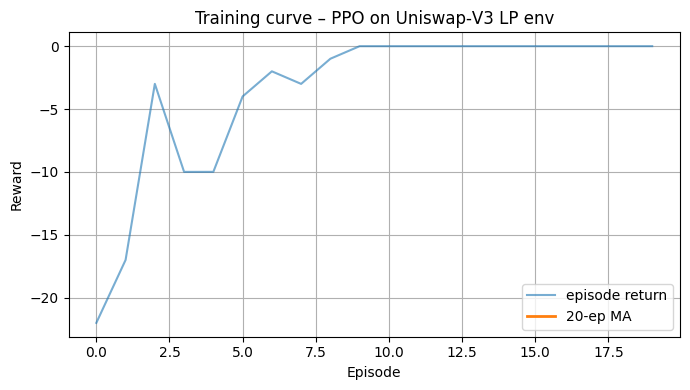

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


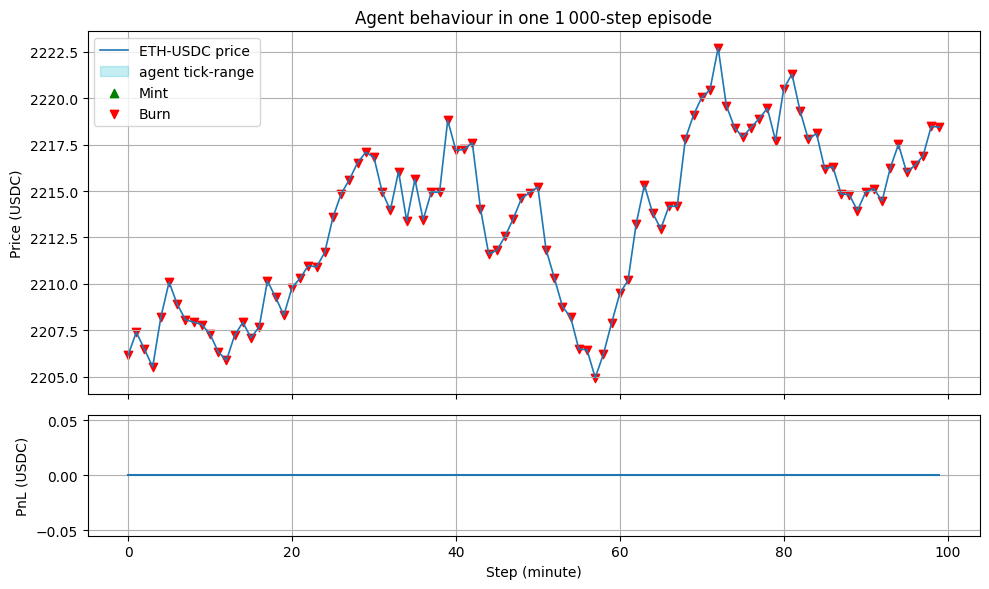

In [15]:
# visualize.py ─────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import torch

# --- helper to convert tick to price ----------------------------------
def tick_to_price(tick: int) -> float:
    sqrtp = 1.0001 ** (tick / 2)
    return sqrtp ** 2


# ╭───────────────────────── 1. learning curve ───────────────────────╮
def plot_learning_curve(log_dir: Path):
    """Assumes exactly one *.monitor.csv in log_dir (latest run)."""
    mon_csv = sorted(log_dir.glob("monitor.csv"))[-1]
    df = pd.read_csv(mon_csv, comment="#")
    ep_returns = df["r"].to_numpy()
    ma = pd.Series(ep_returns).rolling(20).mean()

    plt.figure(figsize=(7, 4))
    plt.plot(ep_returns, label="episode return", alpha=0.6)
    plt.plot(ma, label="20‑ep MA", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training curve – PPO on Uniswap‑V3 LP env")
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.show()


# ╭───────────────────────── 2. policy playback ───────────────────────╮
def run_episode_and_plot(model, env):
    """Roll one 1 000‑step episode, record price / actions, then plot."""
    obs, _ = env.reset()
    prices, plow, phigh = [], [], []
    mints_x, mints_y, burns_x, burns_y = [], [], [], []
    cum_pnl = []

    done = False
    step = 0
    while not done and step < 1_000:
        # ---- snapshot *before* acting --------------------------------
        ts = env.decision_grid[env.idx]
        p  = env._eth_price(ts)

        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, trunc, info = env.step(action)

        # ---- log ------------------------------------------------------
        prices.append(p)
        if env.active:
            plow.append(tick_to_price(env.tick_l))
            phigh.append(tick_to_price(env.tick_u))
        else:
            plow.append(np.nan); phigh.append(np.nan)

        if action[0] == 1:                           # Mint
            mints_x.append(step); mints_y.append(p)
        elif action[0] == 0 and env.active is False: # Burn executed
            burns_x.append(step); burns_y.append(p)

        cum_pnl.append(env.cumulative_pnl)
        step += 1

    t = np.arange(len(prices))

    # ── plot –──────────────────────────────────────────────────────────
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                            gridspec_kw={"height_ratios": [3, 1]})

    # (a) price + liquidity range
    axs[0].plot(t, prices, label="ETH‑USDC price", linewidth=1.2)
    axs[0].fill_between(t, plow, phigh, color="tab:cyan", alpha=0.25,
                        label="agent tick‑range")
    axs[0].scatter(mints_x, mints_y, marker="^", color="green", label="Mint")
    axs[0].scatter(burns_x, burns_y, marker="v", color="red", label="Burn")
    axs[0].set_ylabel("Price (USDC)")
    axs[0].set_title("Agent behaviour in one 1 000‑step episode")
    axs[0].legend(loc="upper left"); axs[0].grid(True)

    # (b) cumulative PnL
    axs[1].plot(t, cum_pnl, label="cumulative PnL")
    axs[1].set_ylabel("PnL (USDC)")
    axs[1].set_xlabel("Step (minute)")
    axs[1].grid(True)

    plt.tight_layout(); plt.show()


# ╭───────────────────────── 3.  how to call  ─────────────────────────╮
if __name__ == "__main__":
    # paths must match those in train script
    LOG_DIR   = Path("logs")
    MODEL_DIR = Path("models")

    # 1)  learning curve
    plot_learning_curve(LOG_DIR)

    # 2)  load latest model & make playback plot
    latest_model = sorted(MODEL_DIR.glob("ppo_uniswap_*.zip"))[-1]
    from stable_baselines3 import PPO
    from env_nikolai2 import UniswapV3LPGymEnv
    from config.env_config import Config

    env = UniswapV3LPGymEnv(Config(), feat_num=19)     # same env, no wrappers
    env.EPISODE_LEN = 100                           # ensure 1 000‑step ep
    model = PPO.load(latest_model, env=env)
    run_episode_and_plot(model, env)
